# 1. Preprocessing, POS Tagging and Syntax-Aware Features

In [2]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from nltk import pos_tag, bigrams, trigrams

# Downloads
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Init tools
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

# Load your dataset
df = pd.read_csv("labeled_data.csv")[['tweet', 'class']].dropna()

# Clean text (remove URLs, mentions, hashtags, punctuation)
def clean_text(text):
    text = re.sub(r"http\S+|@\S+|#[A-Za-z0-9_]+|[^A-Za-z\s]", '', text)
    return text.strip().lower()

# Lemmatize
def lemmatize(text):
    return " ".join([lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)])

# Add POS features
def add_pos_features(text):
    tokens = tokenizer.tokenize(text)
    tags = pos_tag(tokens)
    
    # POS tag strings
    pos_unigrams = " ".join([tag for word, tag in tags])
    pos_bigrams = " ".join(["_".join(pair) for pair in bigrams([tag for _, tag in tags])])
    pos_trigrams = " ".join(["_".join(tri) for tri in trigrams([tag for _, tag in tags])])
    
    return {
        "noun_count": sum(1 for _, t in tags if t.startswith('NN')),
        "verb_count": sum(1 for _, t in tags if t.startswith('VB')),
        "adj_count": sum(1 for _, t in tags if t.startswith('JJ')),
        "pos_unigrams": pos_unigrams,
        "pos_bigrams": pos_bigrams,
        "pos_trigrams": pos_trigrams
    }

# Apply everything
df['cleaned'] = df['tweet'].apply(clean_text).apply(lemmatize)
pos_df = df['cleaned'].apply(lambda x: pd.Series(add_pos_features(x)))

# Combine everything
df = pd.concat([df, pos_df], axis=1)
df.rename(columns={"class": "label"}, inplace=True)
df.to_csv("preprocessed_with_pos_features.csv", index=False)

print("Preprocessing completed and saved to preprocessed_with_pos_features.csv")
df[['tweet', 'cleaned', 'noun_count', 'verb_count', 'adj_count']].head()

Preprocessing completed and saved to preprocessed_with_pos_features.csv


,tweet,cleaned,noun_count,verb_count,adj_count
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt a a woman you shouldnt complain about clean...,4,6,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dat coldtyga dwn bad for cuffin dat hoe...,9,0,2
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch and she start...,5,5,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt she look like a tranny,2,1,0
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true or...,2,6,2


In [3]:
# POS tag features 
print("POS unigrams:")
df[['pos_unigrams']].head()

POS unigrams:


,pos_unigrams
0,VB DT DT NN PRP VBP VB IN VBG RP PRP$ NN VBZ D...
1,NN NN NN NN NN JJ IN NN NN NN IN DT JJ NN
2,NN NN NN PRP RB VBD DT NN CC PRP VBP TO VB PRP...
3,NN PRP VBP IN DT NN
4,VB DT NN PRP VBP IN PRP MD VB JJ CC PRP MD VB ...


In [4]:
print("POS bigrams:")
df[['pos_bigrams']].head()

POS bigrams:


,pos_bigrams
0,VB_DT DT_DT DT_NN NN_PRP PRP_VBP VBP_VB VB_IN ...
1,NN_NN NN_NN NN_NN NN_NN NN_JJ JJ_IN IN_NN NN_N...
2,NN_NN NN_NN NN_PRP PRP_RB RB_VBD VBD_DT DT_NN ...
3,NN_PRP PRP_VBP VBP_IN IN_DT DT_NN
4,VB_DT DT_NN NN_PRP PRP_VBP VBP_IN IN_PRP PRP_M...


In [5]:
print("POS trigrams:")
df[['pos_trigrams']].head()

POS trigrams:


,pos_trigrams
0,VB_DT_DT DT_DT_NN DT_NN_PRP NN_PRP_VBP PRP_VBP...
1,NN_NN_NN NN_NN_NN NN_NN_NN NN_NN_JJ NN_JJ_IN J...
2,NN_NN_NN NN_NN_PRP NN_PRP_RB PRP_RB_VBD RB_VBD...
3,NN_PRP_VBP PRP_VBP_IN VBP_IN_DT IN_DT_NN
4,VB_DT_NN DT_NN_PRP NN_PRP_VBP PRP_VBP_IN VBP_I...


# 2. GRU Model: Training, Evaluation and Saving the Model

In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


# Load cleaned dataset
df = pd.read_csv("preprocessed_with_pos_features.csv")[['cleaned', 'label']].dropna()
texts = df['cleaned'].values
labels = to_categorical(df['label'].values, num_classes=3)

# Tokenize
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=100)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Build GRU model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=100),
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

# Save
model.save("gru_model.h5")
print("GRU model saved as gru_model.h5")


Epoch 1/5
620/620 [==============================] - 64s 92ms/step - loss: 0.3750 - accuracy: 0.8640 - val_loss: 0.2799 - val_accuracy: 0.9019
Epoch 2/5
620/620 [==============================] - 55s 89ms/step - loss: 0.2227 - accuracy: 0.9203 - val_loss: 0.2952 - val_accuracy: 0.9001
Epoch 3/5
620/620 [==============================] - 55s 88ms/step - loss: 0.1656 - accuracy: 0.9416 - val_loss: 0.3289 - val_accuracy: 0.8932
Epoch 4/5
620/620 [==============================] - 55s 89ms/step - loss: 0.1214 - accuracy: 0.9560 - val_loss: 0.3695 - val_accuracy: 0.8775
Epoch 5/5
155/155 [==============================] - 5s 26ms/step
[[  63  196   23]
 [  64 3642   92]
 [  14  213  647]]
              precision    recall  f1-score   support

           0       0.45      0.22      0.30       282
           1       0.90      0.96      0.93      3798
           2       0.85      0.74      0.79       874

    accuracy                           0.88      4954
   macro avg       0.73      0.64  

## Confusion Matrix Visualization

155/155 [==============================] - 4s 26ms/step


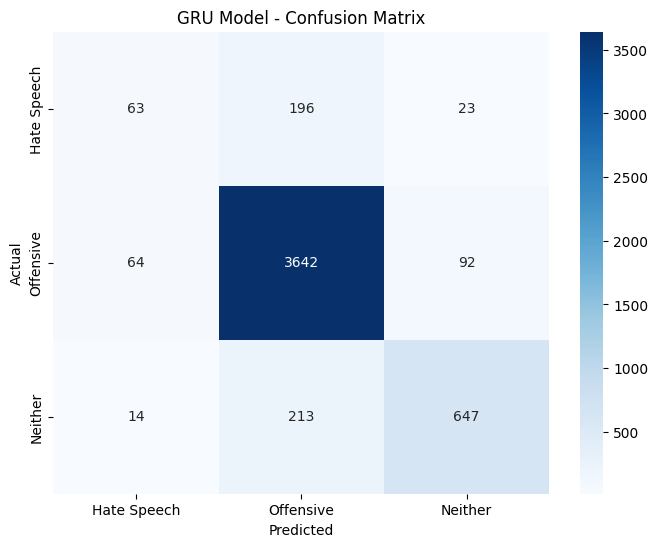

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get actual and predicted labels
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['Hate Speech', 'Offensive', 'Neither']

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GRU Model - Confusion Matrix')
plt.show()


# 3. BERT Model: Training, Visualization and Saving the Model

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch
from datasets import Dataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

# Load and preprocess data
df = pd.read_csv("preprocessed_with_pos_features.csv")[['cleaned', 'label']].dropna()
df.rename(columns={"cleaned": "text", "label": "labels"}, inplace=True)
dataset = Dataset.from_pandas(df)
tokenizer_bert = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer_bert(example['text'], truncation=True, padding='max_length', max_length=128)

tokenized = dataset.map(tokenize, batched=True)
train_test = tokenized.train_test_split(test_size=0.2)

# Initialize model
model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model_bert.to("cuda")

training_args = TrainingArguments(
    output_dir="bert_model",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir="bert_logs",
    logging_steps=10,
    disable_tqdm=False
)

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_test["train"],
    eval_dataset=train_test["test"],
)

# Train
trainer.train()

# Predict and extract logits
predictions = trainer.predict(train_test["test"])
bert_logits = predictions.predictions
y_pred_bert = np.argmax(bert_logits, axis=1)
y_true_bert = np.array(train_test["test"]["labels"])

Map: 100%|██████████████████████████████████████████████████████████████| 24766/24766 [00:04<00:00, 5044.78 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.817000
20,0.570500
30,0.555400
40,0.456900
50,0.500400
60,0.432600
70,0.421000
80,0.558100
90,0.303500
100,0.325000



Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.38      0.44       279
           1       0.94      0.96      0.95      3825
           2       0.87      0.90      0.89       850

    accuracy                           0.91      4954
   macro avg       0.78      0.74      0.76      4954
weighted avg       0.91      0.91      0.91      4954


Confusion Matrix:
 [[ 105  152   22]
 [  81 3656   88]
 [  14   73  763]]


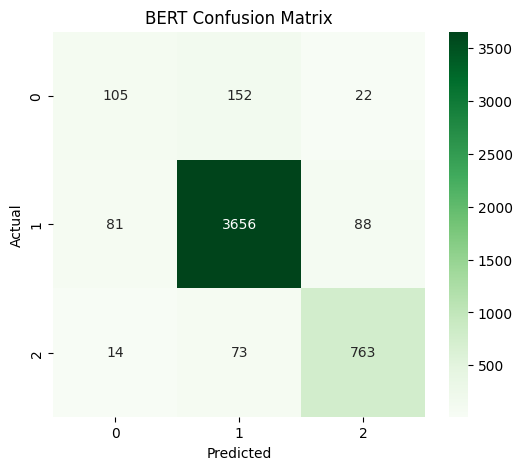

('bert_model\\tokenizer_config.json',
 'bert_model\\special_tokens_map.json',
 'bert_model\\vocab.txt',
 'bert_model\\added_tokens.json',
 'bert_model\\tokenizer.json')

In [9]:
# Evaluation
print("\nClassification Report:\n", classification_report(y_true_bert, y_pred_bert))
print("\nConfusion Matrix:\n", confusion_matrix(y_true_bert, y_pred_bert))

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true_bert, y_pred_bert), annot=True, fmt='d', cmap='Greens')
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model & tokenizer
model_bert.save_pretrained("bert_model")
tokenizer_bert.save_pretrained("bert_model")

# 4. ROC Curve Comparison

155/155 [==============================] - 5s 28ms/step


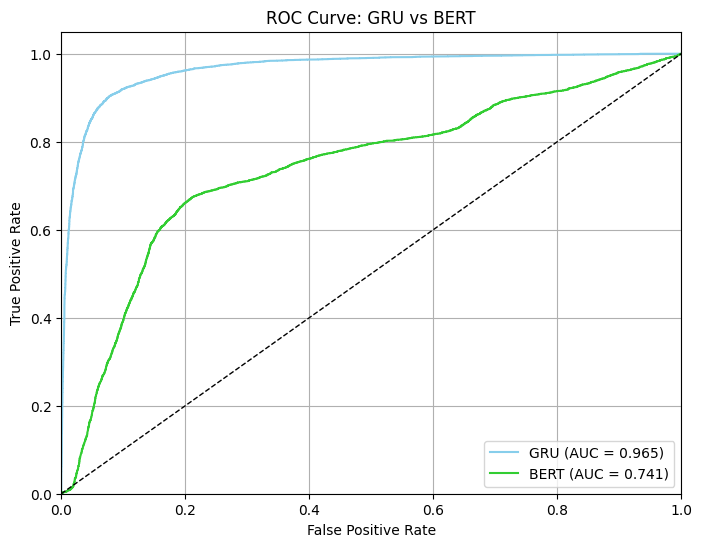

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from scipy.special import softmax

# Binarize true labels
y_test_bin = label_binarize(np.argmax(y_test, axis=1), classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# GRU scores are already softmax
y_score_gru = model.predict(X_test)
fpr_gru, tpr_gru, _ = roc_curve(y_test_bin.ravel(), y_score_gru.ravel())
roc_auc_gru = auc(fpr_gru, tpr_gru)

# BERT: apply softmax to logits
bert_probs = softmax(np.array(bert_logits), axis=1)
fpr_bert, tpr_bert, _ = roc_curve(y_test_bin.ravel(), bert_probs.ravel())
roc_auc_bert = auc(fpr_bert, tpr_bert)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gru, tpr_gru, color='skyblue', label=f"GRU (AUC = {roc_auc_gru:.3f})")
plt.plot(fpr_bert, tpr_bert, color='limegreen', label=f"BERT (AUC = {roc_auc_bert:.3f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: GRU vs BERT')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# 5. Saving the Better Model

In [12]:
if roc_auc_bert > roc_auc_gru:
    print(f"[INFO] BERT performed better (AUC: {roc_auc_bert:.4f})")
    model_bert.save_pretrained("final_model")
    tokenizer_bert.save_pretrained("final_model")
else:
    print(f"[INFO] GRU performed better (AUC: {roc_auc_gru:.4f})")
    model.save("final_model.h5")

[INFO] GRU performed better (AUC: 0.9654)
